In [1]:
folder_names = ['/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re4100/pr07_re4100_6.6K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re4100/pr07_re4100_10.9K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re4100/pr07_re4100_12.2K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re4100/pr07_re4100_15.8K/',
                
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re6500/pr07_re6500_4.3K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re6500/pr07_re6500_6.7K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re6500/pr07_re6500_8.6K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re6500/pr07_re6500_10.0K/',
                
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re8500/pr07_re8500_3.7K/',
                #'/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re8500/pr07_re8500_5.9K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re8500/pr07_re8500_6.5K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re8500/pr07_re8500_8.3K/',
                '/Users/yoshi/Dropbox/measurements/pr07_heatflux/pr07_re8500/pr07_re8500_10.4K/'
               ]
prandtl = 7

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import csv
import os
import codecs
import time
import seaborn as sns
import statistics 
import scipy.stats

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
fontsize_legend = 12#16 
linesize_legend = 4 
plt.rc('legend',fontsize=fontsize_legend)
plt.rc('xtick',labelsize=12)#16
plt.rc('ytick',labelsize=12)#16

In [3]:
# Material properties for Ethylen Glycol
A = 2.0148;
B = 4.50E-3;
def cp(T):
    cp = (A + B * (T+273.15));
    return cp
def cp_K(T):
    cp_K = A + B * (T);
    cp_K =  cp_K *1000;##???
    return cp_K
C = 0.2134;
D = 6.071E-4;
def Lambda(T):
    Lambda = C + D * (T+273.15);
    return Lambda
def Lambda_K(T):
    Lambda_K = C + D * (T);
    return Lambda_K
E = 1.1001E-4;
F = 325.85;
G = -207.30;
def mu(T):
    mu = E * np.exp( F / ( (T+273.15) + G) );
    return mu
def mu_K(T):
    mu_K = E * np.exp( F / ( (T) + G) );
    return mu_K
H = 1268.28;
I = -0.66;
def rho(T):
    rho = H + I * (T+273.15);
    return rho
def rho_K(T):
    rho_K = H + I * (T);
    return rho_K
def nu(T):
    nu = mu(T)/rho(T);
    return nu
def nu_K(T):
    nu_K = mu_K(T)/rho_K(T);
    return nu
def Pr(T):
    Pr = ( mu(T) * cp(T) * 1000 ) / Lambda(T);
    return Pr
def Pr_K(T):
    Pr_K = ( mu_K(T) * cp_K(T)) / Lambda_K(T);
    return Pr

def calculate_mean(data):
    s = sum(data)
    N = len(data)
    mean =s/N
    return mean
def find_difference(data):
    mean = calculate_mean(data)
    diff = []
    for num in data:
        diff.append(num-mean)
    return diff
def calculate_variance(data):
    diff = find_difference(data)
    squared_diff = []
    for d in diff:
        squared_diff.append(d**2)
    sum_squared_diff = sum(squared_diff)
    variance = sum_squared_diff/len(data)
    return variance

#Experimental Facilities
di=12E-3
da=15E-3
ri = di/2
ra = da/2
disoa = 90E-3
L=2
V=(da**2-di**2)*np.pi/4*L
Ageo_MS = di*np.pi*L #円菅内部の試験部表面積
Ugeo_MS = di*np.pi #円菅内面積
Ageo_quer = di**2*np.pi/4
x_pos_TPt100_new =      [0.030, 2.400, 2.600, 2.800, 3.000, 3.000, 3.140, 5.500]
x_pos_TPt100_new_tmp =  [2.400, 2.600, 2.800, 3.000, 3.140]
TPT100_new_tmp =        [0,0,0,0,0]
xTin  = 0.03
xTout = 5.50
x_MS_in = 1.2
x_MS_out = 3.2

# conduction equation for inner wall temperatuer
DeltaK = 0.065E-3
Lambda_N = 20#!!!!!!!!!!!!!!!!!!!!!!!!
Lambda_C = 0.16 #thermal conductivity[W/mK] of capton tape
Lambda_iso = 0.055 #thermal conductivity[W/mK] of glass wool, outer isolation
riso = 0.05 #thickness of isolation
def T1(r,qv,qzu,TN,Ta): #temperature distribution in pipe(ri << r << ra)
    T1 = (qzu/(2*Lambda_N)*ra**2)*(0.5-0.5*(r/ra)**2+np.log(r/ra)) + Ta - qv/Lambda_N*(ra+DeltaK)*(Lambda_N/Lambda_C*np.log(ra/(ra+DeltaK))+np.log(r/ra))
    return T1
def T2(r,qv,Ta):        #temperature distribution in capton tape(ra << r << ra+DeltaK)
    T2 = - qv/Lambda_C*(ra+DeltaK)*np.log(r/(ra+DeltaK)) + Ta
    return T2

In [24]:
where = folder_names[0]
n_samples  = 0
for f_name in sorted(os.listdir(where)):
    n_samples = n_samples + 1
    number_of_stations = np.size(folder_names)
    Re_tau_ave = np.zeros(number_of_stations)
    Re_M_ave = np.zeros(number_of_stations)
    delta_Re_M_ave = np.zeros(number_of_stations)
    cf_M_ave = np.zeros(number_of_stations)
    Nu_M_ave = np.zeros(number_of_stations)
    Pr_w_ave = np.zeros(number_of_stations)
    Pr_m_ave = np.zeros(number_of_stations)
    T_m_ave  = np.zeros(number_of_stations)
    T_w_ave  = np.zeros(number_of_stations)
    TPT100_new0_ave = np.zeros(number_of_stations)
    TPT100_new1_ave = np.zeros(number_of_stations)
    TPT100_new2_ave = np.zeros(number_of_stations)
    TPT100_new3_ave = np.zeros(number_of_stations)
    TPT100_new4_ave = np.zeros(number_of_stations)
    TPT100_new5_ave = np.zeros(number_of_stations)
    TPT100_new6_ave = np.zeros(number_of_stations)
    TPT100_new7_ave = np.zeros(number_of_stations)
    T_in_ave = np.zeros(number_of_stations)
    mu_m_ave = np.zeros(number_of_stations)
    mu_w_ave = np.zeros(number_of_stations)
    drho_ave = np.zeros(number_of_stations)
    rho_m_ave= np.zeros(number_of_stations)
    rho_w_ave= np.zeros(number_of_stations)
    qw_ave   = np.zeros(number_of_stations)
    P_MS_ave = np.zeros(number_of_stations)
    I_MS_ave = np.zeros(number_of_stations)
    Qin_out_ave= np.zeros(number_of_stations)
    mdot_ave = np.zeros(number_of_stations)
    Wmean_ave= np.zeros(number_of_stations)
    delta_p_ave=np.zeros(number_of_stations)
    rho_m_ave= np.zeros(number_of_stations)
    rho_w_ave= np.zeros(number_of_stations)
    cp_m_ave = np.zeros(number_of_stations)
    Lambda_m_ave = np.zeros(number_of_stations)
    
    Re_m_samples = []
    cf_m_samples = []
    Nu_samples = []
    delta_NuMessung_samples = []

for j in range(0,number_of_stations):
    filename_list        = []
    T_in_list            = []
    T_out_list           = []
    Tw_list              = []
    Tm_list              = []
    TPT100_new0_list = []
    TPT100_new1_list = []
    TPT100_new2_list = []
    TPT100_new3_list = []
    TPT100_new4_list = []
    TPT100_new5_list = []
    TPT100_new6_list = []
    TPT100_new7_list = []
    mdot_list            = []
    qw_list              = []
    Re_tau_list          = []
    Re_m_list            = []
    Re_w_list            = []
    ReTau_list           = []
    Pr_m_list            = []
    Pr_w_list            = []
    NuMessung_list       = []
    cf_M_list            = []
    df_list_all          = []
    delta_p_list         = []
    mu_m_list            = []
    mu_w_list            = []
    I_MS_list            = []
    Nu_turb_Gni4Tau_list = []
    P_MS_list            = []
    Qin_out_list         = []
    Wmean_list           = []
    rho_w_list           = []
    rho_m_list           = []
    cp_m_list            = []
    Lambda_m_list        = []
    
    where = folder_names[j]
    
    for fname in sorted(os.listdir(where)):
        filename = where + fname
        if filename == where + 'rubbish':
            continue
        elif filename == where + '.DS_Store':
            continue
        elif filename == where + '.DS_Store.txt':
            continue
        else:
            txt = codecs.open(filename, encoding ='cp1252')
            data = np.loadtxt(txt, skiprows = 1)
            Tsa = data[:,0] #Temperatur aussen: Ts_aussen / °C
            Tsi = data[:,1] #Temperatur innen: Ts innen / °C
            Ti = data[:,2] #Fluidtemperatur: T / °C
            m_dot_C1 = data[0,3] #Massenstrom: m_dot C1 / kg/h
            m_dot_C2 = data[0,4] #Massenstrom: m_dot C2 / kg/h
            Re_C1 = data[0,5] #Re C1 / -
            Re_C2 = data[0,6] #Re C2 / -
            v_C1 = data[0,7] #Geschwindigkeit: v C1 / m/s
            v_C2 = data[0,8] #Geschwindigkeit: v C2 / m/s
            U_MS = data[0,9] #Spannungsabfall Messstrecke: U_MS / V
            I_MS = data[0,10] #Strom Messstrecke: I_MS / A
            P_MS = data[0,11] #Leistung Messstrecke: P_MS / W
            q = data[0,12] #spzifische Leistung: q / W/m3
            P1 = data[0,13] #Druckmessung: P1 / Pa
            P2 = data[0,14] #Druckmessung: P2 / Pa
            dp = data[0,15] #Differenzdruck: dp / bar
            nu_Fluid = data[0,16] #kin. Viscositaet Fluid: nu / m2/s
            rho_Fluid = data[0,17] #Dichte Fluid: rho / kg/m3
            Lambda_Fluid = data[0,18] #Waermeleitfaehigkeit Fluid: lambda / W/mK
            cp_Fluid = data[0,19] #spez. Waermekapazitaet Fluid: cp /J/kgK
            Pr_Fluid = data[0,20] #Pr / -
            Lambda_Rohr = data[0,21] #Waermeleitfaehigkeit Rohr: lambda / W/mK
            Nu_Fluid = data[0,22] #Nu / -
            I1 = data[0,23] #Strom I / A
            U1 = data[0,24] #Spannung U / V
            dp_T1 = data[0,25] #Re_tau / - 関数名とtxtが合っていない？
            dp_T2 = data[0,26] #Re_tau_Pet / -　関数名とtxtが合っていない？
            dp_T3 = data[0,27] #dp Pet / Pa
            #Mittel (U*I) mean P / W
            Pm = data[0,28] #Mittel (U*I) mean P / W
            TPT100_a_old = data[:5,29]#PT100 T aussen(5 value)
            TPT100_i_old = data[:5,30]#PT100 T innen(5 value)
            TPT100_m_old = data[:5,31]#PT100 T mittel(5 value)
            TPT100_a_new = data[:8,38]#!!!!!!!!!!!!!
            TPT100_i_new = data[:8,39]
            TPT100_m_new = data[:8,40]
            NuPt100 = data[0,32] #Nu Pt100
            NuQm = data[0,33] #Nu Qm
            # zeta computation Einlesen
            ZRem100 = data[0,34] #zeta Re
            Zzeta100 = data[0,35] #zeta
            Zqm100 = data[0,36] #zeta qw
            TPT100_T5 = data[0,37] #PT100 T5
            TPT100_out = TPT100_a_new
            TPT100_in  = TPT100_i_new
            TPT100_mean= TPT100_m_new
            TPT100_new = TPT100_i_new
            Tm_aus = TPT100_new[7]
            Tm = Tm_aus
            n_samples  = n_samples  + 1
            
            # iteration to update the temperatuer dependent material properties --> new wall temperature 205-339
            # first loop doesnt include dq heat loss.
            for i in range(2):
                Tw = TPT100_new[6]
                T_iso = Ti[1]
                T_inf = Ti[6]
                Pr_w = Pr(Tw)
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                dqhldT = 1
                zeta_mischer = 32.46
                Thl = (Tw + Tm)*0.5
                qhl = dqhldT * (Thl - T_iso)
                qhlm2 = qhl / (da*np.pi*5.45)
                Re_m = Re_C1
                Lambda_Pet = (1.8*np.log10(Re_m)-1.5)**(-2)
                
                #Specific heat capasity, cp mean
                T_in = TPT100_new[0] + 273.15
                T_out = TPT100_new[7] + 273.15
                Ac = 2.0148
                Bc = 4.50E-3
                cpm = (Ac*(T_out-T_in)+Bc/2*(T_out**2-T_in**2))/(T_out-T_in)*1000 #Eq(2.108)
                Wmean = Re_m*nu_m/di #velocisty
                mdot = m_dot_C1/3600

                TPT100_new_tmp[0] = TPT100_new[1]
                TPT100_new_tmp[1] = TPT100_new[2]
                TPT100_new_tmp[2] = TPT100_new[3]
                TPT100_new_tmp[3] = 0.5 * (TPT100_new[4] + TPT100_new[5])
                TPT100_new_tmp[4] = TPT100_new[6]
                fit = np.polyfit(x_pos_TPt100_new_tmp, TPT100_new_tmp,1)
                gradT_PT100 = fit[0]
                Q_Pt100 = gradT_PT100*mdot*cpm*L
                qUI = P_MS/Ageo_MS
                dqw2 = (Lambda_Pet*(5.45-2.92)/di + zeta_mischer) * rho_m * Wmean**2 /2 * Wmean * Ageo_quer - qhl*(5.45-2.53)/5.45
                
                Qin_out = mdot*cpm*(T_out-T_in)
                dQ = Qin_out-P_MS
                gradT = (Qin_out/L) / (mdot * cpm )
                dTm = dqw2/(mdot*cpm)
                SA_Tm = gradT*(x_MS_out-x_pos_TPt100_new[6])
                Tm_aus = TPT100_new[7] - dTm
                Tm = Tm_aus - SA_Tm
                
                qw = Qin_out/ Ageo_MS
                if(Qin_out>0):
                    qvA=qhlm2
                else:
                    qvA=0
                
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                P=Pm
                P=P_MS
                Re_m = m_dot_C1/3600.*4./(nu_m*rho_m*di*np.pi)
                Re_w = m_dot_C1/3600.*4./(nu_w*rho_m*di*np.pi)
                #Wall temperature calibration
                qVol = Qin_out / V
                Tw = T1(ri,qvA,qVol,TPT100_a_new[6], TPT100_a_new[6])
                Tw_SA6 = T1(ri,qvA,qVol, TPT100_a_new[5], TPT100_a_new[5])
                Tw_SA5 = T1(ri,qvA,qVol, TPT100_a_new[4], TPT100_a_new[4])
                Tw_SA4 = T1(ri,qvA,qVol, TPT100_a_new[3], TPT100_a_new[3])
                Tw_SA3 = T1(ri,qvA,qVol, TPT100_a_new[2], TPT100_a_new[2])
                Tw_SA2 = T1(ri,qvA,qVol, TPT100_a_new[1], TPT100_a_new[1])
                Tw_SA1 = T1(ri,qvA,qVol, TPT100_a_new[0], TPT100_a_new[0])
                Tw_SA8 = T1(ri,qvA,qVol, TPT100_a_new[7], TPT100_a_new[7])
                TPT100_new[6] = Tw
                TPT100_new[0] = Tw_SA1
                TPT100_new[1] = Tw_SA2
                TPT100_new[2] = Tw_SA3
                TPT100_new[3] = Tw_SA4
                TPT100_new[4] = Tw_SA5
                TPT100_new[5] = Tw_SA6
                TPT100_new[7] = Tw_SA8
                
                Nu_QmdotCpDt_w = qw * di / (Lambda_w * (Tw-Tm ))
                NuMessung = Nu_QmdotCpDt_w
                tau_w = dp*di/(1.*4.)
                
                ###ADDDDDDDDDDD!!!!!!!!!
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
            
                w_tau=(tau_w/rho_m)**(1./2.) #share velocity
                ReTau = w_tau*di/nu_w

                Wmean = Re_m*nu_m/di
                cf_M = tau_w/(rho_m*Wmean**2./2.) #Friction coefficient Eq(4.8)
        
        filename_list.append(filename)
        T_in_list.append(T_in)
        T_out_list.append(T_out)
        Tw_list.append(Tw)
        Tm_list.append(Tm)
        TPT100_new0_list.append(TPT100_new[0])
        TPT100_new1_list.append(TPT100_new[1])
        TPT100_new2_list.append(TPT100_new[2])
        TPT100_new3_list.append(TPT100_new[3])
        TPT100_new4_list.append(TPT100_new[4])
        TPT100_new5_list.append(TPT100_new[5])
        TPT100_new6_list.append(TPT100_new[6])
        TPT100_new7_list.append(TPT100_new[7])
        mdot_list.append(mdot)
        qw_list.append(qw)
        Re_m_list.append(Re_m)
        Re_w_list.append(Re_w)
        Re_tau_list.append(ReTau)
        ReTau_list.append(ReTau)
        Pr_m_list.append(Pr_m)
        Pr_w_list.append(Pr_w)
        NuMessung_list.append(NuMessung)
        cf_M_list.append(cf_M)
        
        mu_m_list.append(mu_m)
        mu_w_list.append(mu_w)
        delta_p_list.append(dp)
        
        I_MS_list.append(I_MS)
        P_MS_list.append(P_MS)
        Qin_out_list.append(Qin_out)
        
        rho_m_list.append(rho_m)
        rho_w_list.append(rho_w)
        cp_m_list.append(cp_m)
        Lambda_m_list.append(Lambda_m)
        Wmean_list.append(Wmean)
        
    T_w_ave[j]    = sum(Tw_list)         /len(Tw_list)
    T_m_ave[j]    = sum(Tm_list)         /len(Tm_list)
    T_in_ave[j]   = sum(T_in_list)       /len(T_in_list)
    TPT100_new0_ave[j] = sum(TPT100_new0_list)/len(TPT100_new0_list)
    TPT100_new1_ave[j] = sum(TPT100_new1_list)/len(TPT100_new1_list)
    TPT100_new2_ave[j] = sum(TPT100_new2_list)/len(TPT100_new2_list)
    TPT100_new3_ave[j] = sum(TPT100_new3_list)/len(TPT100_new3_list)
    TPT100_new4_ave[j] = sum(TPT100_new4_list)/len(TPT100_new4_list)
    TPT100_new5_ave[j] = sum(TPT100_new5_list)/len(TPT100_new5_list)
    TPT100_new6_ave[j] = sum(TPT100_new6_list)/len(TPT100_new6_list)
    TPT100_new7_ave[j] = sum(TPT100_new7_list)/len(TPT100_new7_list)
    qw_ave[j]     = sum(qw_list)         /len(qw_list)
    Re_tau_ave[j]     = sum(Re_tau_list)     /len(Re_tau_list)
    Re_M_ave[j]   = sum(Re_m_list)       /len(Re_m_list)
    Pr_m_ave[j]   = sum(Pr_m_list)       /len(Pr_m_list)
    Pr_w_ave[j]   = sum(Pr_w_list)       /len(Pr_w_list)
    Nu_M_ave[j]   = sum(NuMessung_list)  /len(NuMessung_list)
    cf_M_ave[j]   = sum(cf_M_list)       /len(cf_M_list)
    mu_m_ave[j]   = sum(mu_m_list)       /len(mu_m_list)
    mu_w_ave[j]   = sum(mu_w_list)       /len(mu_w_list)
    drho_ave[j]   = rho(T_m_ave[j])      -rho(T_w_ave[j])
    I_MS_ave[j]   = sum(I_MS_list)       /len(I_MS_list)
    P_MS_ave[j]   = sum(P_MS_list)       /len(P_MS_list)
    Qin_out_ave[j]= sum(Qin_out_list)    /len(Qin_out_list) 
    mdot_ave[j]   = sum(mdot_list)       /len(mdot_list) 
    Wmean_ave[j]  = sum(Wmean_list)      /len(Wmean_list)
    delta_p_ave[j]= sum(delta_p_list)    /len(delta_p_list)
    rho_m_ave[j]  = sum(rho_m_list)      /len(rho_m_list)
    rho_w_ave[j]  = sum(rho_w_list)      /len(rho_w_list)
    cp_m_ave[j]   = sum(cp_m_list)       /len(cp_m_list)
    Lambda_m_ave[j]=sum(Lambda_m_list)   /len(Lambda_m_list)
    
    
    if j == 0:
        Re_m_samples = Re_m_list
        cf_m_samples = cf_M_list
        Nu_samples   = NuMessung_list
    else: 
        Re_m_samples.extend(Re_m_list)
        cf_m_samples.extend(cf_M_list)
        Nu_samples.extend(NuMessung_list)

### Measurement Uncertainty

In [25]:
#### absolute error
T_e = 0.04                     #New PT100
mdot_e = 0.20E-3 * mdot_ave    #mass flow rate [kg / s]
p_e = 0.35E-3 * delta_p_ave    #pressure[Pa]
rho_e = 0.66 * T_e             #density [kg / m^3]
cp_e = 4.5 * T_e               #specific heat capasity [J / kg K]
Lambda_e = 6.071e-4 * T_e      #thermal conductivity of fluid [W / m K]

#Uncertainty in each measurement influencing
delta_mdot   = (mdot_e  /mdot_ave)**2
delta_cp     = (cp_e    /cp_m_ave)**2
delta_Lambda = (Lambda_e/Lambda_m_ave)**2 
delta_T      = (T_e/(T_in_ave-T_m_ave))**2 + ((T_e * (T_in_ave-T_w_ave)) / ((T_in_ave-T_m_ave)*(T_m_ave-T_w_ave)))**2 + (T_e/(T_m_ave-T_w_ave))**2
delta_p      = (p_e / delta_p_ave)**2
delta_rho    = (rho_e / rho_m_ave)**2

#Measurement uncertainty for NuMessung
delta_Nu = Nu_M_ave * ((delta_mdot + delta_cp + delta_Lambda + delta_T)**0.5)

#measurement uncertainty of Cf
delta_cf_M = cf_M_ave * ((delta_p + 4*delta_mdot + delta_rho)**0.5)

#Measurement uncertainty of Re
#Re_M_ave*((mdot_e/mdot_ave)+(rho_e/rho_m_ave))

### Condition list

In [29]:
print('Pr_w, Re_M,     cf,   Nu, Tin,  Tout, Tw,  dT,dmu/mu, qw')
for i in range(len(Re_M_ave)):
    print(round(Pr_w_ave[i],1), round(Re_M_ave[i]), round(cf_M_ave[i],5), round(Nu_M_ave[i],1), 
          round(T_in_ave[i]-273.15,2), round(T_m_ave[i],2), round(T_w_ave[i],2), round(T_w_ave[i] - T_m_ave[i],1), 
           round(((mu_m_ave[i]-mu_w_ave[i])/mu_m_ave[i])*100, 1), round(qw_ave[i]))

Pr_w, Re_M,     cf,   Nu, Tin,  Tout, Tw,  dT,dmu/mu, qw
7.0 3931.0 0.01063 38.5 82.72 88.54 95.11 6.6 8.3 9213.0
7.0 3846.0 0.01151 38.3 75.35 84.48 95.38 10.9 13.6 15182.0
7.0 3902.0 0.00955 39.3 72.92 83.03 95.23 12.2 15.3 17463.0
7.0 3805.0 0.00907 38.6 66.82 79.29 95.11 15.8 19.8 22220.0
7.0 6564.0 0.00847 62.9 87.03 90.89 95.23 4.3 5.4 9945.0
7.0 6492.0 0.00815 63.6 82.6 88.36 95.02 6.7 8.4 15423.0
7.0 6296.0 0.00817 62.2 79.58 86.94 95.56 8.6 10.8 19554.0
6.9 6312.0 0.00774 63.0 77.31 85.72 95.67 10.0 12.4 22831.0
7.0 8684.0 0.00875 79.6 88.55 91.73 95.44 3.7 4.7 10788.0
7.0 8423.0 0.00854 79.5 83.41 88.82 95.32 6.5 8.1 18792.0
6.9 8213.0 0.00877 78.4 80.67 87.56 95.9 8.3 10.4 23823.0
7.0 8189.0 0.00845 79.1 76.53 84.86 95.21 10.4 13.0 29837.0


### Heat flux

In [19]:
#print(P_MS_ave/Ageo_MS)     #Electric power(Ideal)
#print(Qin_out_ave/Ageo_MS)  #Heat capacity (Reality)
#print(qw_ave)

### Temperature distribution

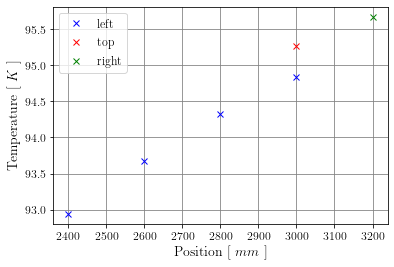

In [22]:
#plt.xlim(2200, 3400)
#plt.ylim(69,72)

#plt.errorbar(30  , TPT100_new0_ave[5], fmt='x', color='orange', label='center')#T_in
plt.errorbar(2400, TPT100_new1_ave[7], fmt='x', color='blue', label='left')
plt.errorbar(2600, TPT100_new2_ave[7], fmt='x', color='blue')
plt.errorbar(2800, TPT100_new3_ave[7], fmt='x', color='blue')
plt.errorbar(3000, TPT100_new4_ave[7], fmt='x', color='blue')
plt.errorbar(3000, TPT100_new5_ave[7], fmt='x', color='red', label='top')
plt.errorbar(3200, TPT100_new6_ave[7], fmt='x', color='green', label='right')#T_w
#plt.errorbar(5500, TPT100_new7_ave[5], fmt='x', color='orange')#T_out

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Position $[\ mm\ ]$', fontsize=fontsize_legend+2)
plt.ylabel(r'Temperature $[\ K\ ]$', fontsize=fontsize_legend+2)
#plt.title(r'For $Pr_{w}=10.0$, $Re=6337$ and $\Delta T=10.2$', fontsize=fontsize_legend+2)
plt.legend(loc='upper left')
#leg = ax.legend(loc='upper right',prop={'size': 8}, framealpha=0.2)

#OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr10_temperature_distribution_re6337_dt10.2.pdf'
#plt.tight_layout()
#plt.savefig(OutPutFig)

### Cf vary with wall heat flux

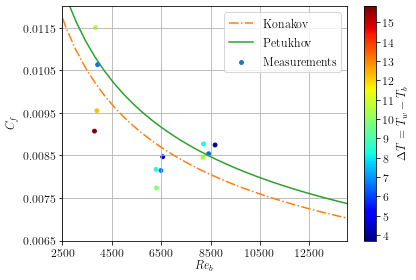

In [9]:
Re_lam = np.linspace(1,2300,)
Re_turb = np.linspace(2300,21000,)
#Skin friction for laminar flow
Cf_lam = 16 / Re_lam
#Skin friction for turbulent flow
Cf_Konakov =   0.25 * (1.8*np.log10(Re_turb) - 1.5)**(-2)
Cf_Petukhov =  0.25 * (1.8*np.log10(Re_turb) - 1.64)**(-2)

upRe = 14001
upCf = 0.0121#0.0111
upNu = 140

x  = Re_M_ave#[0:24]
y  = cf_M_ave#[0:24]
dt = T_w_ave-T_m_ave
yerr = delta_cf_M_ave

bounds = np.linspace(0,14,16)#(0,14,15)
labels = np.linspace(1,16,16)#(1,14,14)
fig, ax = plt.subplots()#(figsize=(10,6))
im = ax.scatter(x, y, alpha=None, s=15, c=dt, cmap=plt.cm.jet, label='Measurements')

plt.grid(True)
plt.xlim(2500,14001)
plt.ylim(0.0065, 0.0120)#plt.ylim(0.0065, 0.0105)
cb = fig.colorbar(im, ax=ax, ticks=labels,)# boundaries=bounds)

plt.plot(Re_turb, Cf_Konakov,linestyle="dashdot", color='tab:orange', label="Konakov")
plt.plot(Re_turb, Cf_Petukhov,linestyle="solid", color='tab:green', label="Petukhov")

#plt.errorbar([4165, 6574], [,], fmt='^', color='black',  elinewidth=3, capsize=1, label="DNS", alpha=0.6)
#plt.errorbar([8498, 11465], [,], fmt='v', color='black',  elinewidth=3, capsize=1, label="LES", alpha=0.6)
plt.errorbar(x, y, yerr = yerr, fmt=' ', ecolor='gray', alpha=0.3)

ax.xaxis.set_ticks(np.arange(2500,upRe,2000))
ax.yaxis.set_ticks(np.arange(0.0065,upCf,0.001))

plt.legend(loc='upper right',prop={'size': 12})#,framealpha=0.2)

plt.xlabel(r'$Re_{b}$', fontsize=12)
plt.ylabel(r'$C_{f}$', fontsize=12) #for $Pr_{w}=\ $ + str(prandtl)
#plt.cb.set_label(r'Temperature difference')
cb.set_label(r'$\Delta T$\ = $T_{w} - T_{b}$', fontsize=12)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_recfdt.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

### Nu vary with wall heat flux

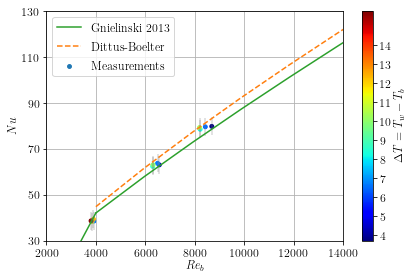

In [23]:
Pr_correlation = np.mean(Pr_w_ave)

Re_lam = np.linspace(1.,2300.,)
Re_tran = np.linspace(2300.,4000.,)
Re_turb = np.linspace(4000.,100000.,)

#laminar
Nu_lam1 = 3.66
Nu_lam2 = 0.7
Nu_lam3 = 1.615 * (Re_lam * Pr_correlation * di / L)**(1./3.)
Nu_lam = (Nu_lam1**3. + Nu_lam2**3. + Nu_lam3**3.)**(1./3.)
#turbulent
xi_Kon = (0.79 * np.log10(Re_turb) - 1.64)**(-2.)#Konakov
xi_Pet = (1.8 * np.log10(Re_turb) - 1.5)**(-2.)#Petukhov
Nu_turb_Pet = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) * (1. + (di/L)**(2./3.))
Nu_turb_Gni = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

#xi_Pet_no_corr = (1.8 * np.log10(Re_tot) - 1.5)**(-2.)
#Nu_Gni_no_corr = ((xi_Pet_no_corr/8. * Re_tot * Pr_correlation) / (1. + 12.7 * (xi_Pet_no_corr/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

#transitional
c1 = Nu_lam[49]
c2 = Nu_turb_Gni[0]
r = (Re_tran - 2300.) / (4000. - 2300.)
Nu_tran = (1. - r) * c1 + r * c2

#Dittus_Boelter correlation
NuDB = 0.027*Re_turb**0.8 * Pr_correlation**0.4
#Entrance factor
entrance_section = 1.2
n = 2.08E-6 * Re_turb - 0.815
Nu_entrance = 1 + 23.99 * Re_turb **(-0.23) * (entrance_section / di)**n
#Roughness factor
epcylon = 3.2E-6 #assumed
Nu_roughness = 0.091 * (epcylon / di)**(-0.125) * Re_turb**(0.363*(epcylon/di)**0.1)
#Viscosity factor
Nu_viscosity = (mu_m_ave / mu_w_ave)**0.14
#Combining the four factors
Nu_Robinson = NuDB * Nu_entrance * Nu_roughness# * Nu_viscosity


x  = Re_M_ave#[0:24]
y  = Nu_M_ave#[0:24]
yerr = delta_NuMessung

bounds = np.linspace(0,14,15)
labels = np.linspace(1,14,14)
fig, ax = plt.subplots()#(figsize=(10,6))
im = ax.scatter(x, y, alpha=None, s=15, c=dt, cmap=plt.cm.jet, label='Measurements')
plt.errorbar(x, y, yerr = yerr, fmt=' ', ecolor='gray', alpha=0.3)
cb = fig.colorbar(im, ax=ax, ticks=labels)# boundaries=bounds)

#im = ax.scatter([4165, 6587], [43.8176, 68.9527], alpha=None, s=30, c=[15,15], marker='s', cmap=plt.cm.jet, label='DNS')
#plt.errorbar([4165, 6587], [,], fmt='^', color='black',  elinewidth=3, capsize=1, label="DNS", alpha=0.6)
#plt.errorbar([8498, 11465], [,], fmt='v', color='black',  elinewidth=3, capsize=1, label="LES", alpha=0.6)

plt.grid(True)
plt.xlim(2500,14001)
plt.ylim(30,130)

#Emperical correlation
plt.plot(Re_lam, Nu_lam, color='tab:green',linestyle="solid", label="Gnielinski 2013")
plt.plot(Re_tran, Nu_tran, color='tab:green',linestyle="solid")
plt.plot(Re_turb, Nu_turb_Gni, color='tab:green',linestyle="solid")
plt.plot(Re_turb, NuDB, color='tab:orange',linestyle="dashed", label="Dittus-Boelter")


ax.xaxis.set_ticks(np.arange(2000,upRe,2000))
ax.yaxis.set_ticks(np.arange(30,upNu,20))
plt.legend(loc='upper left',prop={'size': 12})#,framealpha=0.2)

plt.xlabel(r'$Re_{b}$', fontsize=12)
plt.ylabel(r'$Nu$', fontsize=12) #for $Pr_{w}=\ $ + str(prandtl)
#plt.cb.set_label(r'Temperature difference')

cb.set_label(r'$\Delta T$\ = $T_{w} - T_{b}$', fontsize=12)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_renudt.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

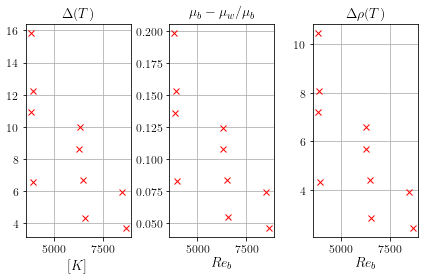

In [42]:
fig = plt.figure(3)
ax1=plt.subplot(131)
plt.plot(Re_M_ave, T_w_ave - T_m_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[K]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta{(T)}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(132) 
plt.plot(Re_M_ave, (mu_m_ave-mu_w_ave)/mu_m_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
#plt.title (r'$\Delta \mu{(T)}$' ,fontsize=fontsize_legend+2)
plt.title (r'$\mu_{b}-\mu_{w}/\mu_{b}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(133) 
plt.plot(Re_M_ave, drho_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$\Delta \rho{(T)}$' ,fontsize=fontsize_legend+2)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_deltaT.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [ ]:
test = []
for i in range(420):
    test.append(i)

fig = plt.figure(3)
ax1=plt.subplot(111) 
plt.plot(test, P_MS_list, 'rx')#, label=r'$\Delta \mu{T}$')

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'Electrical power $W$ vary with time for $Re_{b}=4100$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_ep_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)
OutPutFig = './time_vs_w.pdf'

fig = plt.figure(4)
ax1=plt.subplot(111)  
plt.plot(test, delta_p_list,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'$\Delta p$ vary with time for $Re_{b}=4100$',fontsize=fontsize_legend+2)
#plt.title (r'$\Delta p$  vs electrical power VI' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_time_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [ ]:
fig = plt.figure(4)
ax1=plt.subplot(111) 
plt.plot(delta_p_list, P_MS_list, 'rx')#, label=r'$\Delta \mu{T}$')

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'Time',fontsize=fontsize_legend+2)
plt.title (r'Electrical power $W$ vary with time for $Re_{b}=4100$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_ep_vs_pressure.pdf'
plt.tight_layout()

In [ ]:
print(np.corrcoef(P_MS_list, delta_p_list))
#np.corrcoef(delta_p_list, mu_m_list)
print(np.corrcoef(delta_p_list, cf_M_list))

In [ ]:
fig = plt.figure(4)
#ax1=plt.subplot(231) 
ax1=plt.subplot(111) 
plt.plot(Re_m_list[0:50], mdot_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$m^{3} / s$',fontsize=fontsize_legend+2)
plt.title (r'$ \dot{m}$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_re_vs_massflow.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(5)
ax1=plt.subplot(111) 
#ax1=plt.subplot(232) 
plt.plot(Re_m_list[0:50], delta_p_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_re_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(6)
ax1=plt.subplot(111) 
#ax1=plt.subplot(233) 
plt.plot(Re_m_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50])  ,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_re_vs_mu.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(7)
ax1=plt.subplot(111) 
#ax1=plt.subplot(234) 
plt.plot(delta_p_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50]),  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[-]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $ vs $ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_mu_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(8)
ax1=plt.subplot(111) 
#ax1=plt.subplot(235) 
plt.plot(Re_m_list[0:50], Tw_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$^{\circ}$',fontsize=fontsize_legend+2)
plt.title (r'$ T_{w}$' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_re_vs_Tw.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)


fig = plt.figure(9)
ax1=plt.subplot(111) 
#ax1=plt.subplot(236) 
plt.plot(P_MS_list, delta_p_list,  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'W',fontsize=fontsize_legend+2)
plt.ylabel(r'Pa',fontsize=fontsize_legend+2)
plt.title (r'$\Delta p$  vs electrical power VI' ,fontsize=fontsize_legend+2)
OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_ep_vs_pressure.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

#Measurement 
#plt.errorbar(ReTau_list, NuMessung_list, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")
#plt.errorbar(ReTau_list, Nu_turb_Gni4Tau_list, fmt='.', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")

In [ ]:

print('folders')
print(folder_names)
print('-------------')
print('Prm')
print(Pr_m_ave)
print('-------------')
print('Prw')
print(Pr_w_ave)

print(cf_M_ave)
#print(mu_m_ave)
variance = calculate_variance(cf_M_list)
std = variance**0.5
print(std)
#print(delta_cf_M_list)

In [ ]:
#tips = sns.load_dataset("tips")
g = sns.jointplot(Re_m_samples[0:400], cf_m_samples[0:400], kind="reg")

In [ ]:
#Ref:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
sns.distplot(cf_m_samples[0:192], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True},label='pr7')
sns.distplot(cf_m_samples[397:607], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True}, label='pr10')
sns.distplot(cf_m_samples[607:802], hist=False, kde=True, rug=False, bins=40, kde_kws = {'shade': True}, label='pr20')

plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'frequency' ,fontsize=fontsize_legend+2)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_histgram.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(cf_m_samples[0:192], bins=100, range = (0,0.021), normed = 0, color= 'blue',histtype = 'step',  alpha=0.7, label="pr7")
plt.hist(cf_m_samples[397:706], bins=100, range = (0,0.021), normed = 0, color= 'red',histtype = 'step',alpha=0.7, label="pr10")
plt.hist(cf_m_samples[607:802], bins=100, range = (0,0.021), normed = 0, color= 'green',histtype = 'step', alpha=0.7, label="pr20")

plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'frequency' ,fontsize=fontsize_legend+2)

#plt.xlim(0,0.021)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_histgram.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)

In [ ]:
np.std(cf_m_samples[0:192])

In [ ]:
#Ref:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
#sns.distplot((cf_m_samples[0:192]-np.mean(cf_m_samples[0:192]))/np.std(cf_m_samples[0:192]), hist=True, kde=True, rug=False, bins=40, label='pr7')
#sns.distplot((cf_m_samples[397:607]-np.mean(cf_m_samples[397:607]))/np.std(cf_m_samples[397:607]), hist=True, kde=True, rug=False, bins=40, label='pr10')
sns.distplot((cf_m_samples[607:802]-np.mean(cf_m_samples[607:802]))/np.std(cf_m_samples[607:802]), hist=True, kde=True, rug=False, bins=40, label='pr20')




plt.grid(True)
plt.xlabel(r'sigma',fontsize=fontsize_legend+2)
plt.title (r'Probability density function' ,fontsize=fontsize_legend+2)
plt.legend()
plt.xlim(-4.5,4.5)
#plt.ylim(0,0.025)

OutPutFig = '/Users/yoshi/Desktop/GitHub/graz/doc/master_thesis/fig/pr' + str(prandtl) + 'heatflux_pdf_pr20.pdf'
plt.tight_layout()
#plt.savefig(OutPutFig)